In [2]:


import os

import numpy as np
from PIL import Image
import cv2

import imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from collections import OrderedDict
from PIL import ImageFilter
import torchvision.transforms as transforms
import random
import wandb

In [3]:
class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):

        x = self.conv1(x)
        
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        next_layer = self.max_pool(x)
        skip_layer = x
        
        return next_layer, skip_layer

In [4]:
class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder_block, self).__init__()
        
        self.transpose_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x, skip_layer):
        x = self.transpose_conv(x)
        x = torch.cat([x, skip_layer], axis=1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [5]:
class bottleneck_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(bottleneck_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [6]:
# UNet model
class UNet(nn.Module):
    def __init__(self, n_class=3):
        super(UNet, self).__init__()
        # Encoder blocks
        self.enc1 = encoder_block(3, 64)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)
        
        # Bottleneck block
        self.bottleneck = bottleneck_block(512, 1024)
        
        # Decoder blocks
        self.dec1 = decoder_block(1024, 512)
        self.dec2 = decoder_block(512, 256)
        self.dec3 = decoder_block(256, 128)
        self.dec4 = decoder_block(128, 64)
        
        # 1x1 convolution
        self.out = nn.Conv2d(64, n_class, kernel_size=1, padding='same')
        
    def forward(self, image):
        n1, s1 = self.enc1(image)
        n2, s2 = self.enc2(n1)
        n3, s3 = self.enc3(n2)
        n4, s4 = self.enc4(n3)
        
        n5 = self.bottleneck(n4)
        
        n6 = self.dec1(n5, s4)
        n7 = self.dec2(n6, s3)
        n8 = self.dec3(n7, s2)
        n9 = self.dec4(n8, s1)
        
        output = self.out(n9)
        
        return output

In [7]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
model = UNet()

In [10]:
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): UNet(
    (enc1): encoder_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.3, inplace=False)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (enc2): encoder_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.3, in

In [11]:
path_to_weights = 'unet_model.pth'

# Load the weights into your model
for key in torch.load(path_to_weights, map_location=torch.device('cpu')).keys():
    print(key)
model.load_state_dict(torch.load(path_to_weights, map_location=torch.device('cpu'))['model'])

model
optimizer


<All keys matched successfully>

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match your model's input size
    transforms.ToTensor(),          # Convert image to tensor

])

In [19]:
import os
import torch
from torchvision import transforms
from PIL import Image

# Load your model
# model = ...  # Load your model here

# Define your transformation for inference
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match your model's input size
    transforms.ToTensor(),          # Convert image to tensor

])

# Folder containing images
images_folder = 'Images/'

# List all image files in the folder
image_files = os.listdir(images_folder)
original_img = []
output_img = []
# Perform inference on each image
for img_file in image_files:
    # Load image
    img_path = os.path.join(images_folder, img_file)
    img = Image.open(img_path)
    
    # Apply transformations
    img = transform(img)
    
    # Add batch dimension
    img = img.unsqueeze(0)  # Assuming your model expects a batch dimension
    
    # Put the model in evaluation mode
    model.eval()
    
    # Perform inference
    with torch.no_grad():
        output = model(img)
    img = img.squeeze(0)
    output = output.squeeze(0)
    print(type(img))
    print(img.shape)
    rgb_image = img.cpu().detach().numpy().transpose(1, 2, 0)
    rgb_result = output.cpu().detach().numpy().transpose(1, 2, 0)
    original_img.append(rgb_image)
    output_img.append(rgb_result)


<class 'torch.Tensor'>
torch.Size([3, 224, 224])
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


In [1]:
!pip install plotly


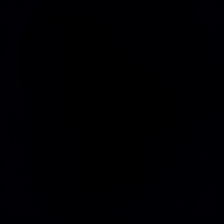

In [22]:
import plotly.express as px
fig = px.imshow(output_img[2], color_continuous_scale='Viridis')
fig.update_layout(coloraxis_showscale=False)
fig.show()

In [23]:
import torch.nn.functional as F